### Homework 5: AirBnB Figures
#### Author: Ceyda Durmaz
#### Date: 11/30/2020
##### Link to GitHub repository: https://github.com/cdurmaz569/Data_Science_I_Homework/tree/master/Homework_5

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load listings data
listings = pd.read_csv("listings.csv")

# Load reviews data
reviews = pd.read_csv("reviews.csv")

# Rename neighborhood column
listings.rename(columns = {'neighbourhood_cleansed':'Neighbourhood'}, inplace = True)

# Set seaborn style
sns.set_style("ticks");

#### Types of Listings in Istanbul 

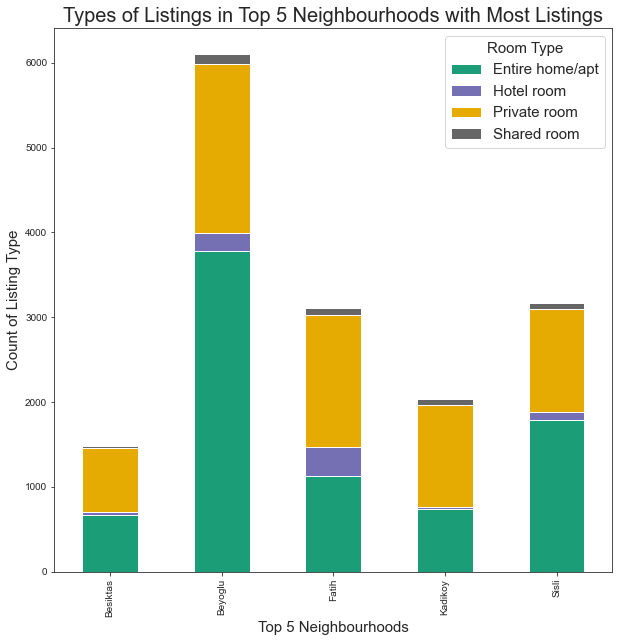

In [3]:
# Get top 5 neighborhoods with most listings
top5 = listings.groupby("Neighbourhood").count()
top5 = top5.sort_values(by = ["id"], ascending=False)
top5 = list(top5.head().index)

# Filter rows by top 5 neighborhoods
listingsTopNeig = listings[listings["Neighbourhood"].isin(top5)]

# Reformat for stacked bar plot
stack = listingsTopNeig.groupby(["Neighbourhood", 
                                 "room_type"])["Neighbourhood"].count().unstack("room_type").fillna(0)

# Plot stacked bar plot
stack.plot.bar(stacked=True, # Specify stacked bar plot
               colormap = "Dark2", # Change color palette
               figsize = (10,10)); # Set figure size
plt.xlabel("Top 5 Neighbourhoods", fontsize = 15); # Rename x axis
plt.ylabel("Count of Listing Type", fontsize = 15); # Rename y axis
plt.legend(title = "Room Type", fontsize = 15, title_fontsize = 15); # Rename legend title
plt.title("Types of Listings in Top 5 Neighbourhoods with Most Listings", fontsize = 20); # Plot title

Figure 1: This plot shows the total number of room types in each of the top 5 neighbourhoods with most AirBnB listings. The two most popular room types across the five neighbourhoods are entire home/apt typically followed by a private room. Fatih district appears to have the most hotel room options while Beyoglu is primarily dominated by entire home/apt listings. All five neighbourhoods offer each of the four types of rooms. 

#### Demand by Month

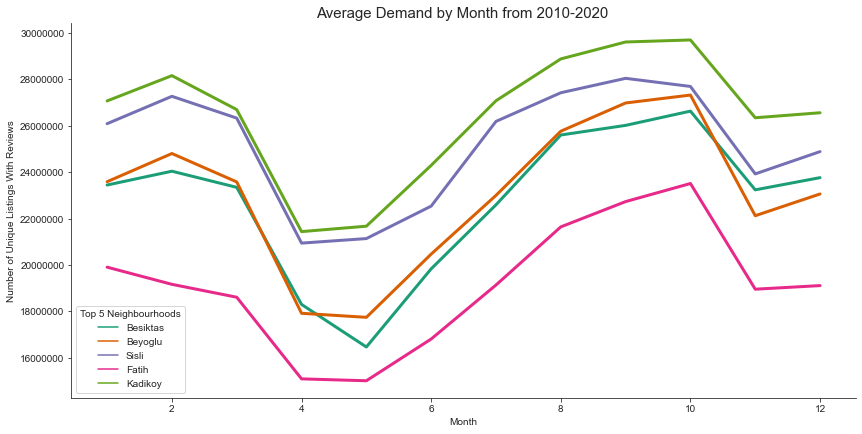

In [4]:
# Get listings with reviews
listingsReviews = pd.merge(listingsTopNeig, reviews, 
                           left_on = "id", 
                           right_on = "listing_id", 
                           how = "left")

# Filter to keep only listings with reviews 
listingsReviews = listingsReviews.dropna(subset = ["listing_id"])

# Create new column with only year and only month
listingsReviews["year"] = pd.DatetimeIndex(listingsReviews["date"]).year
listingsReviews["month"] = pd.DatetimeIndex(listingsReviews["date"]).month

# Drop duplicate listings by month
listingsReviews = listingsReviews.drop_duplicates(subset = ["listing_id", "month"])

# Plot line plot over year
p = sns.relplot(
    data = listingsReviews, 
    kind = "line", # Make line plot
    x = "month", # Specify x axis
    y = "listing_id", # Specify y axis
    hue = "Neighbourhood", # Specify grouping
    ci = None, # Suppress confidence intervals
    palette = "Dark2", # Set color palette
    linewidth = 3 # Change line thickness
)
p._fig.set_size_inches(15,6); # Set figure size
p._legend.remove(); # Remove legend by seaborn
plt.ticklabel_format(style='plain', axis='y'); # Suppress scientific notation 
plt.xlabel("Month"); # Rename x axis
plt.ylabel("Number of Unique Listings With Reviews"); # Rename y axis
plt.legend(title = "Top 5 Neighbourhoods"); # Rename legend title
p.fig.suptitle("Average Demand by Month from 2010-2020", fontsize = 15, x = 0.45); # Plot title, fontsize, and location

Figure 2: This line plot visualizes the average "demand" monthly from the year AirBnB had listings in Istanbul (2010) to 2020. In place of nonexistent booking data for each month, the average number of reviews for unique listings with reviews for that month over 10 years was used. The plot shows that April to June is low season for tourists and October to August is high season. All of the top 5 neighbourhoods with the most listings follow the same trend. 

#### Number of Reviews by Host Status

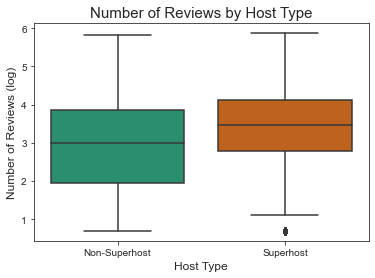

In [5]:
# Subset listings and remove rows where host_is_superhost classifier is NaN
hostReviews = listingsReviews[["host_id", "host_is_superhost", "number_of_reviews"]].dropna(subset = ["host_is_superhost"])

# Rename entries in host_is_superhost column
hostReviews["host_is_superhost"] = hostReviews["host_is_superhost"].replace({"t": "Superhost", "f": "Non-Superhost"})

# Add 1 to number of reviews
hostReviews["number_of_reviews"] = hostReviews["number_of_reviews"] + 1

# Log number of reviews
hostReviews["num_reviews_log"] = np.log(hostReviews["number_of_reviews"])

# Plot boxplot
sns.set_style("ticks")
box = sns.boxplot(data = hostReviews, 
                  x = "host_is_superhost", # Specify x axis
                  y = "num_reviews_log", # Specify y axis
                  palette = "Dark2"); # Set color palette
plt.title("Number of Reviews by Host Type", fontsize = 15); # Plot title
plt.xlabel("Host Type", fontsize = 12); # Rename x axis
plt.ylabel("Number of Reviews (log)", fontsize = 12); # Rename y axis

Figure 3: These box plots shows the comparison of the log transformed number of reviews between hosts classified as superhost and non-superhost. Hosts were included only if their listing had reviews and for clearer visualization, the number of reviews were log transformed. The median number of reviews for superhosts is higher than non-superhosts. 

#### Room Type Pricing Across Neighborhoods

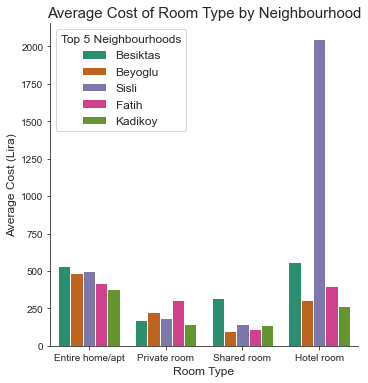

In [6]:
# Convert price to numeric 
listingsReviews["cost"] = listingsReviews["price"].replace('[\$\,]', '', regex=True).astype(float)

# Plot grouped bar graph
grouped = sns.catplot(data = listingsReviews, 
                      kind = "bar", # Make bar plot
                      x = "room_type", # Specify x axis
                      y = "cost", # Specify y axis
                      hue = "Neighbourhood", # Specify grouping
                      palette = "Dark2", # Set color palette
                      ci = None); # Suppress error bars
grouped._legend.remove() # remove seaborn legend
plt.title("Average Cost of Room Type by Neighbourhood", fontsize = 15) # Plot title
plt.xlabel("Room Type", fontsize = 12) # Rename x axis
plt.ylabel("Average Cost (Lira)", fontsize = 12) # Rename y axis
plt.legend(title = "Top 5 Neighbourhoods", fontsize = 12, title_fontsize = 12); # Rename legend title

Figure 4: This grouped bar plot shows the average cost, in Lira, for room types across the top 5 neighbourhoods with listings. For all neighbourhoods, entire homes/apt tend to be more expensive than both private rooms and shared rooms. However, hotel rooms are highly variable among the neighbourhoods, with Sisli having the highest average cost of a hotel room. Overall, Kadikoy tends to have the lowest costs, with the exception of shared room where it is still comparable lower costing Beyoglu and Fatih. 

#### Proximity of Listings

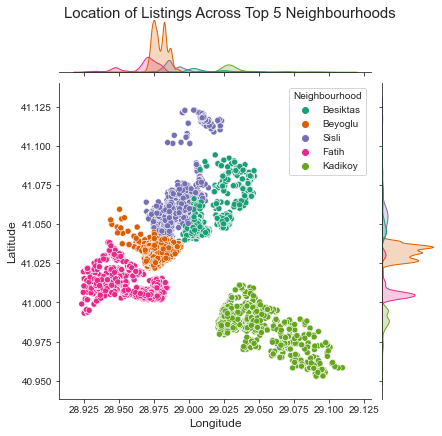

In [7]:
# Plot joint plot of scatterplot and histogram
loc = sns.jointplot(data = listingsReviews, 
                    x = "longitude", # Specify x axis
                    y = "latitude", # Specify y axis
                    hue = "Neighbourhood", # Specify grouping
                    palette = "Dark2"); # Set color palette
loc.fig.suptitle("Location of Listings Across Top 5 Neighbourhoods", fontsize = 15, y = 1) # Plot title, fontsize, and location
loc.set_axis_labels("Longitude", "Latitude", fontsize = 12); # Rename x and y axes

Figure 5: This joint plot displays a scatter plot of listings with reviews based on longitude and latitude across the top 5 neighbourhoods with the most listings. The plot is bordered by histograms of listings for longitude and latitude. Kadikoy is the furthest physically separated from the other four neighbourhoods. The other four neighbourhoods (Besiktas, Beyoglu, Sisli, and Fatih) are all adjacent to one another. Beyoglu and Fatih also have the most listings. The number of listings in concordance with their geographical data makes sense, as the four adjacent districts contain tourist "hotspots" on the European side of Istanbul, while Kadikoy on the Anatolian side consists primarily of residential areas. 